In [1]:
import scipy.io as sio
import torch
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp # Unet

In [2]:
# --------------------
# Device
# --------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
# --------------------
# Load training data
# --------------------
train_X = sio.loadmat("data/train/X.mat")["X"]  # (200, 90, 30)
train_Y = sio.loadmat("data/train/Y.mat")["Y"]

# --------------------
# Min-Max normalization
# --------------------
X_min, X_max = train_X.min(), train_X.max()
Y_min, Y_max = train_Y.min(), train_Y.max()

train_X_norm = (train_X - X_min) / (X_max - X_min)
train_Y_norm = (train_Y - Y_min) / (Y_max - Y_min)

# Convert to torch tensors and add channel dimension
train_X_tensor = torch.tensor(train_X_norm, dtype=torch.float32).unsqueeze(1)
train_Y_tensor = torch.tensor(train_Y_norm, dtype=torch.float32).unsqueeze(1)
train_Y_tensor.shape

torch.Size([200, 1, 30, 90])

In [3]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 50
# --------------------
# Dataset and CV setup
# --------------------
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
import torch.nn as nn
import segmentation_models_pytorch as smp

# SimpleCNN
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv4 = nn.Conv2d(16, out_channels, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.act = nn.ReLU()

    def forward(self, x):
        x1 = self.pool(self.act(self.conv1(x)))
        x2 = self.pool(self.act(self.conv2(x1)))
        x3 = self.up(self.act(self.conv3(x2)))
        x4 = self.up(self.conv4(x3))
        
        # Ensure output matches input size exactly
        x4 = F.interpolate(x4, size=x.shape[2:], mode='bilinear', align_corners=False)
        return x4

# UNet
def get_unet(in_channels=1, out_channels=1):
    return smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None,  # or "imagenet"
        in_channels=in_channels,
        classes=out_channels
    )


In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assume device, train_loader, SimpleCNN, get_unet are defined
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_model(model, train_loader, epochs, lr=1e-3):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    losses = []
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        # Print only every 100 epochs
        if (epoch + 1) % 100 == 0 or epoch == 0:  # also print the first epoch
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.6f}")
    return losses

In [6]:
# ==========
epochs = 1000
# Train Simple CNN
simple_cnn = SimpleCNN()
cnn_losses = train_model(simple_cnn, train_loader, epochs)

# Train UNet
unet_model = get_unet()
unet_losses = train_model(unet_model, train_loader, epochs)


Epoch [1/1000], Loss: 0.372354
Epoch [100/1000], Loss: 0.127830
Epoch [200/1000], Loss: 0.115278
Epoch [300/1000], Loss: 0.109236
Epoch [400/1000], Loss: 0.106357
Epoch [500/1000], Loss: 0.104814
Epoch [600/1000], Loss: 0.103241
Epoch [700/1000], Loss: 0.101701
Epoch [800/1000], Loss: 0.101577
Epoch [900/1000], Loss: 0.101309
Epoch [1000/1000], Loss: 0.100403
Epoch [1/1000], Loss: 0.403660
Epoch [100/1000], Loss: 0.024777
Epoch [200/1000], Loss: 0.009159
Epoch [300/1000], Loss: 0.005543
Epoch [400/1000], Loss: 0.003416
Epoch [500/1000], Loss: 0.002506
Epoch [600/1000], Loss: 0.002325
Epoch [700/1000], Loss: 0.002201
Epoch [800/1000], Loss: 0.001735
Epoch [900/1000], Loss: 0.001546
Epoch [1000/1000], Loss: 0.001466


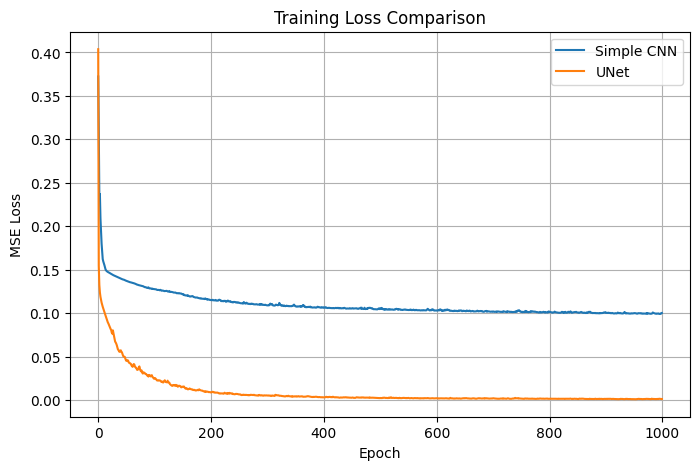

In [7]:
# Plotting loss comparison
plt.figure(figsize=(8,5))
plt.plot(cnn_losses, label="Simple CNN")
plt.plot(unet_losses, label="UNet")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# -------------------------------
# Load validation data
# -------------------------------
val_X = sio.loadmat("data/val/X.mat")["X"]
val_Y = sio.loadmat("data/val/Y.mat")["Y"]

# Normalize using training min/max
val_X_norm = (val_X - X_min) / (X_max - X_min)
val_Y_norm = (val_Y - Y_min) / (Y_max - Y_min)

# Add channel dimension
val_X_tensor = torch.tensor(val_X_norm, dtype=torch.float32).unsqueeze(1).to(device)  # (N,1,H,W)
val_Y_tensor = torch.tensor(val_Y_norm, dtype=torch.float32).unsqueeze(1).to(device)

# -------------------------------
# Function to get predictions and MSE
# -------------------------------
def eval_model(model, X_tensor, Y_tensor):
    model.eval()
    with torch.no_grad():
        Y_pred = model(X_tensor)
    Y_pred_np = Y_pred.cpu().numpy()
    Y_pred_denorm = Y_pred_np * (Y_max - Y_min) + Y_min
    Y_true_denorm = Y_tensor.cpu().numpy() * (Y_max - Y_min) + Y_min
    mse = np.mean((Y_true_denorm - Y_pred_denorm)**2)
    return Y_pred_denorm, Y_true_denorm, mse

# -------------------------------
# Evaluate both models
# -------------------------------
cnn_pred_denorm, Y_true_denorm, cnn_mse = eval_model(simple_cnn, val_X_tensor, val_Y_tensor)
unet_pred_denorm, _, unet_mse = eval_model(unet_model, val_X_tensor, val_Y_tensor)

print(f"CNN Validation MSE: {cnn_mse:.6f}")
print(f"UNet Validation MSE: {unet_mse:.6f}")

CNN Validation MSE: 0.098422
UNet Validation MSE: 0.003431


In [35]:
import time
# Measure
start = time.time()
unet_model.eval()
Y_pred = unet_model(val_X_tensor)
end = time.time()
print("Inference time:", (end - start)/val_X_tensor.shape[0], "seconds")

Inference time: 0.0023893117904663086 seconds


In [36]:
import time
# Measure
start = time.time()
simple_cnn.eval()
Y_pred = simple_cnn(val_X_tensor)
end = time.time()
print("Inference time:", (end - start)/val_X_tensor.shape[0], "seconds")

Inference time: 0.00033020973205566406 seconds


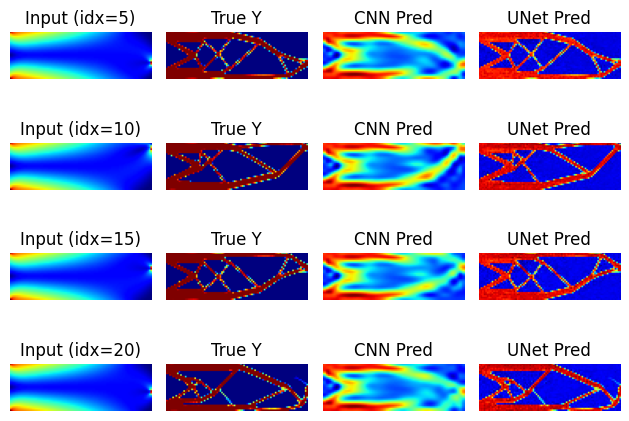

In [23]:

sample_ids = [5, 10, 15, 20]

fig, axes = plt.subplots(4,4)
for row, idx in enumerate(sample_ids):

    axes[row, 0].imshow(val_X[idx], cmap="jet")
    axes[row, 0].set_title(f"Input (idx={idx})")
    axes[row, 0].axis("off")

    axes[row, 1].imshow(Y_true_denorm[idx, 0], cmap="jet")
    axes[row, 1].set_title("True Y")
    axes[row, 1].axis("off")

    axes[row, 2].imshow(cnn_pred_denorm[idx, 0], cmap="jet")
    axes[row, 2].set_title("CNN Pred")
    axes[row, 2].axis("off")

    axes[row, 3].imshow(unet_pred_denorm[idx, 0], cmap="jet")
    axes[row, 3].set_title("UNet Pred")
    axes[row, 3].axis("off")

# Remove extra margins around the figure
fig.tight_layout()
plt.savefig("predictions_4x4.png", bbox_inches="tight")
plt.show()


